1714 246 51 12
Average Costs:
Hourly: $332.51
Daily: $332.60
Weekly: $330.81
Monthly: $318.23


/var/folders/zm/m96r0q8s0sn2krvg5xn10_qr0000gn/T/ipykernel_60945/2988009813.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  market_open_length_week = len(stock_data.index.to_period('W').unique())
/var/folders/zm/m96r0q8s0sn2krvg5xn10_qr0000gn/T/ipykernel_60945/2988009813.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  market_open_length_month = len(stock_data.index.to_period('M').unique())


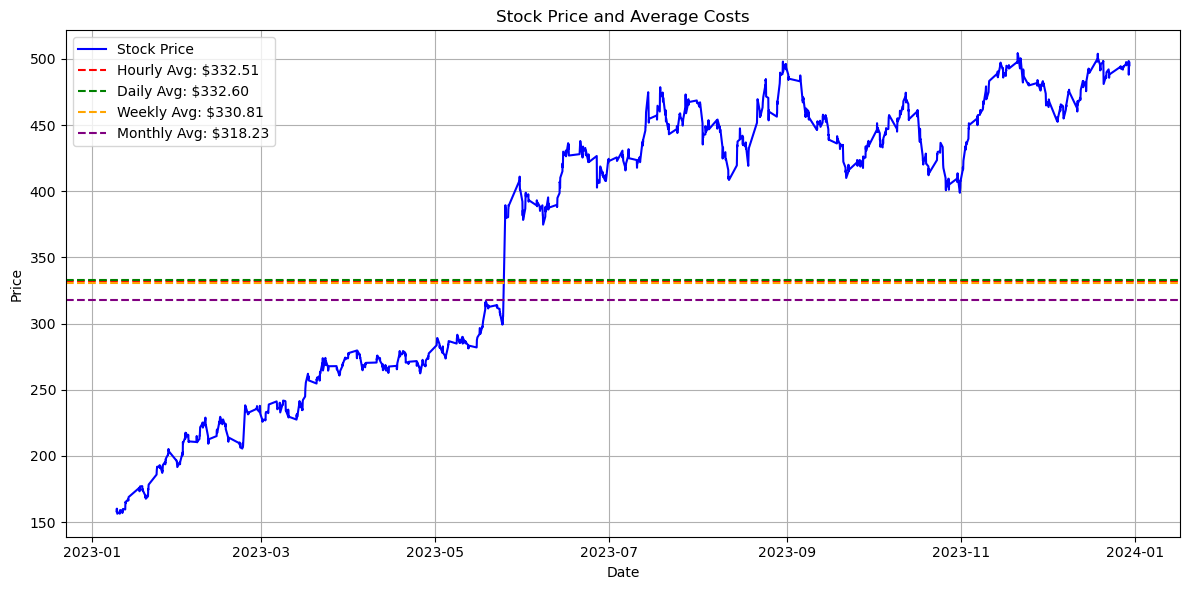

Total shares purchased (Hourly): 118.7838760553031
Total shares purchased (Daily): 118.27118114988149
Total shares purchased (Weekly): 119.40052678263623
Total shares purchased (Monthly): 124.0828466316143


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

def get_data(ticker, start_date, end_date, interval="1h"):
    data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval=interval)
    if data.index.tz is None:
        data.index = data.index.tz_localize('UTC')
    else:
        data.index = data.index.tz_convert('UTC')
    return data

def convert_eur_to_usd(amount, timestamp, forex_data):
    # Ensure timestamp is in the same timezone as forex_data index
    timestamp = pd.Timestamp(timestamp).tz_convert(forex_data.index.tz)
    exchange_rate = forex_data.loc[timestamp, 'Close']
    return amount * exchange_rate

def calculate_average_cost(stock_data, forex_data, spend_eur, time_length):
    # Initialize
    start_date = pd.Timestamp(stock_data.index[0].date())  # Ensure start_date is a Timestamp
    end_date = start_date + timedelta(days=time_length)
    
    market_open_length_hour = len(stock_data.index)
    unique_days = {timestamp.date() for timestamp in stock_data.index}    
    market_open_length_day = len(unique_days)
    market_open_length_week = len(stock_data.index.to_period('W').unique())
    market_open_length_month = len(stock_data.index.to_period('M').unique())
    print(market_open_length_hour, market_open_length_day, market_open_length_week, market_open_length_month)

    # Globals
    global hourly_purchases, daily_purchases, weekly_purchases, monthly_purchases
    hourly_purchases = []
    daily_purchases = []
    weekly_purchases = []
    monthly_purchases = []

    current_date = start_date
    weekly_purchases_flag = 0
    monthly_purchases_flag = 0

    while current_date <= end_date:
        # Hourly purchase
        for hour in range(13, 21):  # Assuming market hours 9 AM to 4 PM NY TIME
            timestamp = pd.Timestamp(current_date.year, current_date.month, current_date.day, hour, 30, tz='UTC')
            timestamp_forex = pd.Timestamp(current_date.year, current_date.month, current_date.day, hour, 0, tz='UTC')
            if timestamp in stock_data.index and timestamp_forex in forex_data.index:
                usd_amount = convert_eur_to_usd(spend_eur, timestamp_forex, forex_data)
                price = stock_data.loc[timestamp, 'Close']
                shares = usd_amount / market_open_length_hour / price
                hourly_purchases.append((timestamp, shares, price))
        
        # Daily purchase
        daily_timestamp = pd.Timestamp(current_date.year, current_date.month, current_date.day, 16, 30, tz='UTC')
        daily_timestamp_forex = pd.Timestamp(current_date.year, current_date.month, current_date.day, 17, 0, tz='UTC')
        if daily_timestamp in stock_data.index and daily_timestamp_forex in forex_data.index:
            usd_amount = convert_eur_to_usd(spend_eur, daily_timestamp_forex, forex_data)
            daily_data = stock_data.loc[daily_timestamp]
            daily_close = daily_data['Close']
            daily_shares = usd_amount / market_open_length_day / daily_close
            daily_purchases.append((daily_timestamp, daily_shares, daily_close))
        
        # Weekly purchase (every Wednesday)
        if current_date.weekday() == 2 or weekly_purchases_flag == 1:  # Wednesday
            if daily_timestamp in stock_data.index and daily_timestamp_forex in forex_data.index:
                usd_amount = convert_eur_to_usd(spend_eur, daily_timestamp_forex, forex_data)
                weekly_data = stock_data.loc[daily_timestamp]
                weekly_close = weekly_data['Close']
                weekly_shares = usd_amount / market_open_length_week / weekly_close
                weekly_purchases.append((daily_timestamp, weekly_shares, weekly_close))
                weekly_purchases_flag = 0
            else: 
                weekly_purchases_flag = 1
        
        # Monthly purchase
        if (current_date.weekday() == 2 and 8 <= current_date.day <= 14) or monthly_purchases_flag == 1:
            if daily_timestamp in stock_data.index and daily_timestamp_forex in forex_data.index:
                usd_amount = convert_eur_to_usd(spend_eur, daily_timestamp_forex, forex_data)
                monthly_data = stock_data.loc[daily_timestamp]
                monthly_close = monthly_data['Close']
                monthly_shares = usd_amount / market_open_length_month / monthly_close
                monthly_purchases.append((daily_timestamp, monthly_shares, monthly_close))
                monthly_purchases_flag = 0
            else:
                monthly_purchases_flag = 1
                
        current_date += timedelta(days=1)
        
    return {
        'hourly': calculate_avg(hourly_purchases),
        'daily': calculate_avg(daily_purchases),
        'weekly': calculate_avg(weekly_purchases),
        'monthly': calculate_avg(monthly_purchases)
    }

def calculate_avg(purchases):
    if not purchases:
        return 0
    
    total_shares = sum(shares for _, shares, _ in purchases)
    total_cost = sum(shares * price for _, shares, price in purchases)
    
    return total_cost / total_shares if total_shares > 0 else 0

def plot_results(data, avg_costs):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Stock Price', color='blue')
    
    # Define a list of colors for the average cost lines
    colors = ['red', 'green', 'orange', 'purple', 'brown']
    
    # Plot each average cost line with a different color
    for (i, (method, avg_cost)) in enumerate(avg_costs.items()):
        color = colors[i % len(colors)]  # Cycle through the colors list
        plt.axhline(y=avg_cost, linestyle='--', color=color, label=f'{method.capitalize()} Avg: ${avg_cost:.2f}')
    
    plt.title('Stock Price and Average Costs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def export_purchases_to_csv(hourly_purchases, daily_purchases, weekly_purchases, monthly_purchases, output_path, export_flag):
    if export_flag == 1:  # Check if the export flag is set to 1
        # Define column names for all types of purchases
        columns = ['Timestamp', 'Shares', 'Price']

        # Convert lists of purchases to DataFrames
        def purchases_to_dataframe(purchases):
            return pd.DataFrame(purchases, columns=columns)
        
        # Convert to DataFrames
        df_hourly = purchases_to_dataframe(hourly_purchases)
        df_daily = purchases_to_dataframe(daily_purchases)
        df_weekly = purchases_to_dataframe(weekly_purchases)
        df_monthly = purchases_to_dataframe(monthly_purchases)

        # Export to CSV
        df_hourly.to_csv(f'{output_path}/hourly_purchases.csv', index=False)
        df_daily.to_csv(f'{output_path}/daily_purchases.csv', index=False)
        df_weekly.to_csv(f'{output_path}/weekly_purchases.csv', index=False)
        df_monthly.to_csv(f'{output_path}/monthly_purchases.csv', index=False)
    else:
        print("Export flag is set to 0. No files have been exported.")

# Main execution
ticker = "NVDA"  # Example ticker for stock
forex_ticker = "EURUSD=X"  # Example ticker for forex, ask for forex name
start_date = "2023-01-08"
end_date = "2023-12-31"
time_length = 365  # Time length in days
spend_eur = time_length * 100  # Whole capital you want to invest in a whole year

stock_data = get_data(ticker, start_date, end_date)
forex_data = get_data(forex_ticker, start_date, end_date)
avg_costs = calculate_average_cost(stock_data, forex_data, spend_eur, time_length)

print("Average Costs:")
for method, avg_cost in avg_costs.items():
    print(f"{method.capitalize()}: ${avg_cost:.2f}")

plot_results(stock_data, avg_costs)

# Export purchases to CSV files
export_purchases_to_csv(
    hourly_purchases, 
    daily_purchases, 
    weekly_purchases, 
    monthly_purchases, 
    "/Volumes/T7 Shield/MacSSD/CodeSSD/scientificProject/CSV",
    1
)

# Function to calculate total shares from the purchases list
def calculate_total_shares(purchases):
    total_shares = sum([shares for _, shares, _ in purchases])  # Sum up the shares (second element)
    return total_shares

# Inside your main function, after the loop
total_shares_hourly = calculate_total_shares(hourly_purchases)
total_shares_daily = calculate_total_shares(daily_purchases)
total_shares_weekly = calculate_total_shares(weekly_purchases)
total_shares_monthly = calculate_total_shares(monthly_purchases)

# Print total shares for each kind to the console
print(f"Total shares purchased (Hourly): {total_shares_hourly}")
print(f"Total shares purchased (Daily): {total_shares_daily}")
print(f"Total shares purchased (Weekly): {total_shares_weekly}")
print(f"Total shares purchased (Monthly): {total_shares_monthly}")

    

Total shares purchased (Hourly): 230.22889259108103
Total shares purchased (Daily): 229.2693529734662
Total shares purchased (Weekly): 230.44042432187123
Total shares purchased (Monthly): 233.0870364977763
Average Costs:
Hourly: $171.73
Daily: $171.76
Weekly: $171.63
Monthly: $169.41


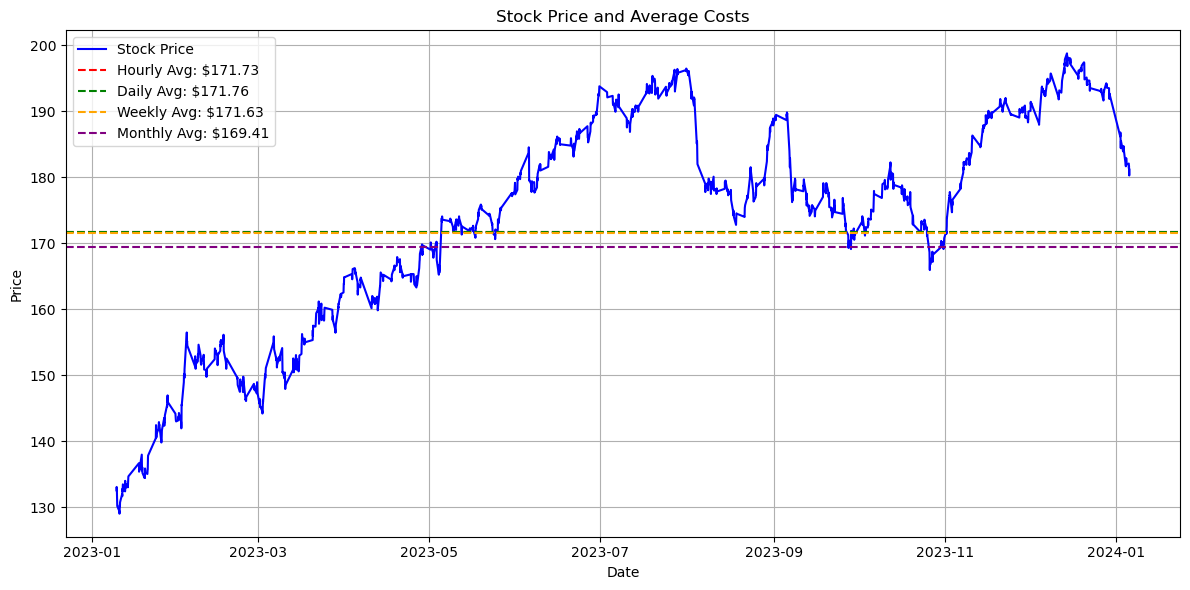

{'Ticker': 'AAPL', 'Forex Ticker': 'EURUSD=X', 'hourly': 171.73435205279517, 'daily': 171.75754775203976, 'weekly': 171.63186509501787, 'monthly': 169.40897033835157}


In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Converting to PeriodArray/Index representation will drop timezone information.")

def process_investment_data(stock_name, forex_name, start_date, time_length, csv_flag=False, matplotlib_flag=False, print_info_flag=False):
    def get_data(ticker, start_date, end_date, interval="1h"):
        data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval=interval)
        if data.index.tz is None:
            data.index = data.index.tz_localize('UTC')
        else:
            data.index = data.index.tz_convert('UTC')
        return data

    def convert_eur_to_usd(amount, timestamp, forex_data):
        timestamp = pd.Timestamp(timestamp).tz_convert(forex_data.index.tz)
        exchange_rate = forex_data.loc[timestamp, 'Close']
        return amount * exchange_rate

    def calculate_average_cost(stock_data, forex_data, spend_eur, time_length):
        start_date = pd.Timestamp(stock_data.index[0].date())
        end_date = start_date + timedelta(days=time_length)

        market_open_length_hour = len(stock_data.index)
        unique_days = {timestamp.date() for timestamp in stock_data.index}    
        market_open_length_day = len(unique_days)
        market_open_length_week = len(stock_data.index.to_period('W').unique())
        market_open_length_month = len(stock_data.index.to_period('M').unique())

        hourly_purchases, daily_purchases, weekly_purchases, monthly_purchases = [], [], [], []

        current_date = start_date
        weekly_purchases_flag, monthly_purchases_flag = 0, 0

        while current_date <= end_date:
            for hour in range(13, 21):  # Assuming market hours 9 AM to 4 PM NY TIME
                timestamp = pd.Timestamp(current_date.year, current_date.month, current_date.day, hour, 30, tz='UTC')
                timestamp_forex = pd.Timestamp(current_date.year, current_date.month, current_date.day, hour, 0, tz='UTC')
                if timestamp in stock_data.index and timestamp_forex in forex_data.index:
                    usd_amount = convert_eur_to_usd(spend_eur, timestamp_forex, forex_data)
                    price = stock_data.loc[timestamp, 'Close']
                    shares = usd_amount / market_open_length_hour / price
                    hourly_purchases.append((timestamp, shares, price))
            
            daily_timestamp = pd.Timestamp(current_date.year, current_date.month, current_date.day, 16, 30, tz='UTC')
            daily_timestamp_forex = pd.Timestamp(current_date.year, current_date.month, current_date.day, 17, 0, tz='UTC')
            if daily_timestamp in stock_data.index and daily_timestamp_forex in forex_data.index:
                usd_amount = convert_eur_to_usd(spend_eur, daily_timestamp_forex, forex_data)
                daily_data = stock_data.loc[daily_timestamp]
                daily_close = daily_data['Close']
                daily_shares = usd_amount / market_open_length_day / daily_close
                daily_purchases.append((daily_timestamp, daily_shares, daily_close))
            
            if current_date.weekday() == 2 or weekly_purchases_flag == 1:  # Wednesday
                if daily_timestamp in stock_data.index and daily_timestamp_forex in forex_data.index:
                    usd_amount = convert_eur_to_usd(spend_eur, daily_timestamp_forex, forex_data)
                    weekly_data = stock_data.loc[daily_timestamp]
                    weekly_close = weekly_data['Close']
                    weekly_shares = usd_amount / market_open_length_week / weekly_close
                    weekly_purchases.append((daily_timestamp, weekly_shares, weekly_close))
                    weekly_purchases_flag = 0
                else: 
                    weekly_purchases_flag = 1
            
            # Monthly purchase
            if (current_date.weekday() == 2 and 8 <= current_date.day <= 14) or monthly_purchases_flag == 1:
                if daily_timestamp in stock_data.index and daily_timestamp_forex in forex_data.index:
                    usd_amount = convert_eur_to_usd(spend_eur, daily_timestamp_forex, forex_data)
                    monthly_data = stock_data.loc[daily_timestamp]
                    monthly_close = monthly_data['Close']
                    monthly_shares = usd_amount / market_open_length_month / monthly_close
                    monthly_purchases.append((daily_timestamp, monthly_shares, monthly_close))
                    monthly_purchases_flag = 0
                else:
                    monthly_purchases_flag = 1

            current_date += timedelta(days=1)
        
        def calculate_avg(purchases):
            if not purchases:
                return 0
            total_shares = sum(shares for _, shares, _ in purchases)
            total_cost = sum(shares * price for _, shares, price in purchases)
            return total_cost / total_shares if total_shares > 0 else 0
        
        return {
            'hourly': calculate_avg(hourly_purchases),
            'daily': calculate_avg(daily_purchases),
            'weekly': calculate_avg(weekly_purchases),
            'monthly': calculate_avg(monthly_purchases)
        }

    def plot_results(stock_data, avg_costs):
        plt.figure(figsize=(12, 6))
        plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', color='blue')
        
        colors = ['red', 'green', 'orange', 'purple', 'brown']
        
        for (i, (method, avg_cost)) in enumerate(avg_costs.items()):
            color = colors[i % len(colors)]
            plt.axhline(y=avg_cost, linestyle='--', color=color, label=f'{method.capitalize()} Avg: ${avg_cost:.2f}')
        
        plt.title('Stock Price and Average Costs')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def export_purchases_to_csv(hourly_purchases, daily_purchases, weekly_purchases, monthly_purchases, output_path, export_flag):
        if export_flag:
            columns = ['Timestamp', 'Shares', 'Price']
            def purchases_to_dataframe(purchases):
                return pd.DataFrame(purchases, columns=columns)
            
            df_hourly = purchases_to_dataframe(hourly_purchases)
            df_daily = purchases_to_dataframe(daily_purchases)
            df_weekly = purchases_to_dataframe(weekly_purchases)
            df_monthly = purchases_to_dataframe(monthly_purchases)

            df_hourly.to_csv(f'{output_path}/hourly_purchases.csv', index=False)
            df_daily.to_csv(f'{output_path}/daily_purchases.csv', index=False)
            df_weekly.to_csv(f'{output_path}/weekly_purchases.csv', index=False)
            df_monthly.to_csv(f'{output_path}/monthly_purchases.csv', index=False)
            print("Files have been exported.")

    # Retrieve stock and forex data
    end_date = (pd.Timestamp(start_date) + timedelta(days=time_length)).strftime('%Y-%m-%d')
    stock_data = get_data(stock_name, start_date, end_date)
    forex_data = get_data(forex_name, start_date, end_date)
    
    # Calculate average costs
    avg_costs = calculate_average_cost(stock_data, forex_data, time_length, time_length)

    # Print information if flag is set
    if print_info_flag:
        
        def calculate_total_shares(purchases):
            total_shares = sum([shares for _, shares, _ in purchases])  # Sum up the shares (second element)
            return total_shares
        
        total_shares_hourly = calculate_total_shares(hourly_purchases)
        total_shares_daily = calculate_total_shares(daily_purchases)
        total_shares_weekly = calculate_total_shares(weekly_purchases)
        total_shares_monthly = calculate_total_shares(monthly_purchases)     
        print(f"Total shares purchased (Hourly): {total_shares_hourly}")
        print(f"Total shares purchased (Daily): {total_shares_daily}")
        print(f"Total shares purchased (Weekly): {total_shares_weekly}")
        print(f"Total shares purchased (Monthly): {total_shares_monthly}")
        
        print("Average Costs:")
        for method, avg_cost in avg_costs.items():
            print(f"{method.capitalize()}: ${avg_cost:.2f}")

    # Plot data if flag is set
    if matplotlib_flag:
        plot_results(stock_data, avg_costs)

    # Export purchases to CSV if flag is set
    output_path = "/path/to/output"  # Change this to your desired output path
    export_purchases_to_csv(
        hourly_purchases,
        daily_purchases,
        weekly_purchases,
        monthly_purchases,
        output_path,
        csv_flag
    )

    # Return the average costs along with the ticker names
    return {
        'Ticker': stock_name,
        'Forex Ticker': forex_name,
        **avg_costs
    }

# Example usage
result = process_investment_data(
    stock_name="AAPL",
    forex_name="EURUSD=X",
    start_date="2023-01-08",
    time_length=365,
    csv_flag=False,
    matplotlib_flag=True,
    print_info_flag=True
)

print(result)


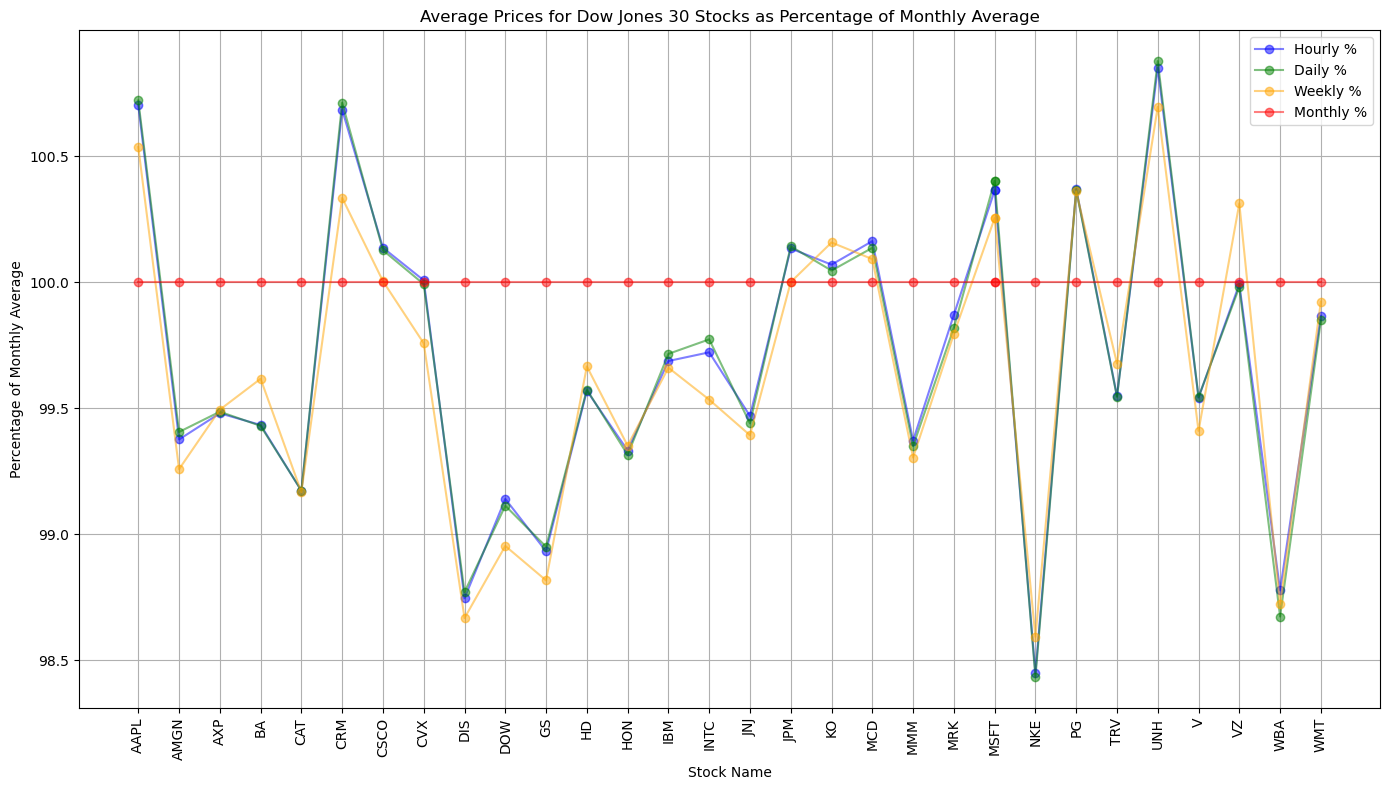

In [16]:
# Define the Dow Jones 30 stock tickers
dow_jones_30 = [
    "AAPL", "MSFT", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS",
    "DOW", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD",
    "MMM", "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT"
]

# Prepare lists to store results for plotting
data = {'Stock': [], 'Hourly': [], 'Daily': [], 'Weekly': [], 'Monthly': []}

# Parameters for analysis
start_date = "2023-01-01"
time_length = 365  # Time length in days
forex_name = "EURUSD=X"

# Analyze each stock
for stock in dow_jones_30:
    result = process_investment_data(
        stock_name=stock,
        forex_name=forex_name,
        start_date=start_date,
        time_length=time_length,
        csv_flag=False,  # Turn off CSV output
        matplotlib_flag=False,  # Turn off plotting
        print_info_flag=False  # Print average costs to console
    )
    
    # Extract average costs
    hourly_avg = result['hourly']
    daily_avg = result['daily']
    weekly_avg = result['weekly']
    monthly_avg = result['monthly']
    
    # Add to data
    data['Stock'].append(stock)
    data['Hourly'].append(hourly_avg)
    data['Daily'].append(daily_avg)
    data['Weekly'].append(weekly_avg)
    data['Monthly'].append(monthly_avg)

# Convert data to DataFrame
df = pd.DataFrame(data)

# Calculate percentages relative to the Monthly average
df['Hourly %'] = (df['Hourly'] / df['Monthly']) * 100
df['Daily %'] = (df['Daily'] / df['Monthly']) * 100
df['Weekly %'] = (df['Weekly'] / df['Monthly']) * 100
df['Monthly %'] = (df['Monthly'] / df['Monthly']) * 100  # This will be 100%

# Save to CSV file
#csv_file_path = '/path/to/your/directory/dow_jones_30_avg_prices_percent.csv'  # Update the path as needed
#df.to_csv(csv_file_path, index=False)
#print(f"Average prices saved to {csv_file_path}")

# Plot results
plt.figure(figsize=(14, 8))

# Sort DataFrame by Stock names to ensure consistency
df = df.sort_values(by='Stock')

# Define colors for the plot (you can adjust the color list based on your preference)
colors = ['blue', 'green', 'orange', 'red']

# Plot each type of average percentage
for i, (kind, color) in enumerate(zip(['Hourly %', 'Daily %', 'Weekly %', 'Monthly %'], colors)):
    plt.plot(df['Stock'], df[kind], color=color, linestyle='-', marker='o', alpha=0.5, label=f'{kind}')

plt.title('Average Prices for Dow Jones 30 Stocks as Percentage of Monthly Average')
plt.xlabel('Stock Name')
plt.ylabel('Percentage of Monthly Average')
plt.xticks(rotation=90)  # Rotate stock names for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [40]:
%reset